In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install pillow


In [2]:
!rm -rf Capstone_ML
!git clone https://github.com/elluy-gabriel-p/Capstone_ML.git
!ls Capstone_ML/data/Dataset_makanan_indonesia/

Cloning into 'Capstone_ML'...
remote: Enumerating objects: 3236, done.
remote: Counting objects: 100% (830/830), done.
remote: Compressing objects: 100% (794/794), done.
remote: Total 3236 (delta 41), reused 817 (delta 32), pack-reused 2406 (from 1)
Receiving objects: 100% (3236/3236), 288.06 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (91/91), done.
Updating files: 100% (4812/4812), done.
'ayam bakar'   bakso		'gado gado'   gulai_tambusu   lumpia	    telur_balado
 ayam_goreng   daging_rendang	 grontol      gulai_tunjang   putu_ayu	    telur_dadar
 ayam_pop      dendeng_batokok	 gulai_ikan   lanting	      serabi_solo   wajik


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter dataset
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data Augmentation dan Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotasi gambar
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Distorsi shearing
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest',  # Isi ulang piksel hilang
    validation_split=0.2  # 20% untuk validasi
)

# Path dataset
DATASET_PATH = '/content/Capstone_ML/data/Dataset_makanan_indonesia'

# Load Data Training dan Validation
try:
    train_data = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_data = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )
except FileNotFoundError as e:
    print(f"Error: {e}. Please check the dataset path and structure.")


Found 2437 images belonging to 18 classes.
Found 604 images belonging to 18 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load MobileNetV2 tanpa top layer
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Awalnya freeze semua layer

# Tambahkan layer custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Regularisasi L2
x = Dropout(0.4)(x)  # Tingkatkan dropout rate
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Kurangi learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks: Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tuning: Melatih beberapa layer terakhir dari base_model
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Hanya buka 50 layer terakhir
    layer.trainable = False

# Latih model
EPOCHS = 50
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 857ms/step - accuracy: 0.1804 - loss: 4.9690 - val_accuracy: 0.5662 - val_loss: 3.9069
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 48s 585ms/step - accuracy: 0.6825 - loss: 3.3548 - val_accuracy: 0.6887 - val_loss: 3.2845
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 83s 592ms/step - accuracy: 0.8138 - loss: 2.7960 - val_accuracy: 0.7169 - val_loss: 3.0749
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 603ms/step - accuracy: 0.8796 - loss: 2.5081 - val_accuracy: 0.7185 - val_loss: 2.9662
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 624ms/step - accuracy: 0.8769 - loss: 2.3923 - val_accuracy: 0.7252 - val_loss: 2.8713
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 581ms/step - accuracy: 0.9163 - loss: 2.2247 - val_accuracy: 0.7699 - val_loss: 2.7011
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - accuracy: 0.9168 - loss: 2.1410 - val_accuracy: 0.8113 - val_loss: 2.4885
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 45s 545ms/step - accuracy: 0.9335 - loss: 1.9914 - val_accuracy: 0.783

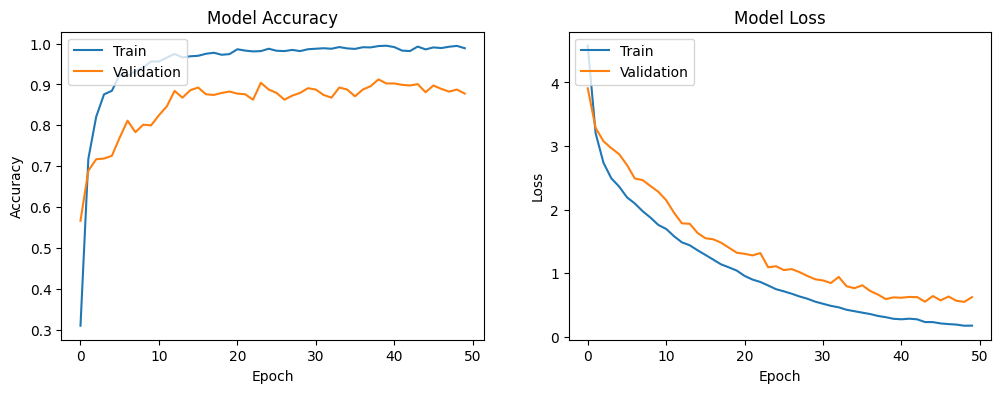

In [5]:
# Monitor Training Progress

import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [6]:
import pandas as pd
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Path ke file CSV kalori di GitHub
CSV_URL = "https://raw.githubusercontent.com/elluy-gabriel-p/Capstone_ML/refs/heads/main/data/dataset_kalori.csv"

# Membaca file CSV
kalori_data = pd.read_csv(CSV_URL)

# Membuat dictionary untuk memetakan makanan ke kalori
kalori_dict = pd.Series(kalori_data['kalori'].values, index=kalori_data['nama_makanan']).to_dict()

# Fungsi untuk prediksi dan menampilkan kalori
def predict_food_and_calories(uploaded_file, model, class_indices, kalori_dict):
    # Load image
    img = image.load_img(uploaded_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi nama makanan
    predictions = model.predict(img_array)
    class_names = list(class_indices.keys())
    predicted_class = class_names[np.argmax(predictions)]

    # Ambil jumlah kalori dari dictionary
    calories = kalori_dict.get(predicted_class, "Kalori tidak ditemukan")

    return predicted_class, calories

# Loop tanpa henti untuk terus mengunggah dan mendeteksi gambar
while True:
    print("Silakan upload gambar makanan untuk deteksi (Tekan Stop Execution untuk keluar):")
    uploaded = files.upload()  # Widget untuk mengunggah gambar

    if uploaded:
        for file_name in uploaded.keys():
            print(f"Processing file: {file_name}")

            # Gunakan model yang telah dilatih
            class_indices = train_data.class_indices

            # Prediksi gambar yang diunggah dan tampilkan hasil
            predicted_food, calories = predict_food_and_calories(file_name, model, class_indices, kalori_dict)
            print(f"The predicted food is: {predicted_food}")
            print(f"Calories: {calories}")


Silakan upload gambar makanan untuk deteksi (Tekan Stop Execution untuk keluar):


KeyboardInterrupt: 

In [7]:
from google.colab import files

#simpan model h5
model.save('/content/Capstone_ML/models/food.h5')

#Download model h5
files.download('/content/Capstone_ML/models/food.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
#simpan model keras
model.save('/content/Capstone_ML/models/food.keras')

#Download model keras
files.download('/content/Capstone_ML/models/food.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>